In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis, sklearn.linear_model
import time
import scipy.stats
import copy

root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils
from code_utils import decoding_utils
from code_utils import stats_utils, plot_utils


In [2]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 7
subjects = np.arange(1,8)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [3]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
   

In [4]:
from code_utils import grid_utils
grid_pts = grid_utils.get_main_grid()
# NOTE i am swapping the columns here
# because this is the order you get from doing np.unique(pts)
# this is the actual order that the predictions 1-16 of this classifier
# correspond to. 
grid_pts = grid_pts[:,[1,0]] 

In [5]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_multiclass_withintask.npy')
dec_withintask = np.load(save_filename, allow_pickle=True).item()
dec_withintask.keys()
roi_names = dec_withintask['roi_names']
n_rois = len(roi_names)

#### compute confusion matrices for 16-way classifier

In [6]:
n_pts = grid_pts.shape[0]

grid_confusion = np.zeros((n_subjects, n_rois, n_tasks, n_pts, n_pts), dtype=int)

for si, ss in enumerate(subjects):

    for ti, tt in enumerate([1,2,3,4]):
        
        l = lab[ss][lab[ss]['task']==tt]
        
        pt_labs = np.array([l['ptx'], l['pty']]).T.round(2)
        # nn_pts = np.array([l['nn_ptx'], l['nn_pty']]).T.round(2)
        
        pt_inds = np.zeros((pt_labs.shape[0],), dtype=int)
        for tr in range(pt_labs.shape[0]):
            ind = np.argmin(np.sum((pt_labs[tr,:]-grid_pts)**2, axis=1))
            pt_inds[tr] = ind
            
        
        is_main_grid = l['is_main_grid']==1
       
        correct = np.array(l['subject_correct'])
        
        
        for ri in range(n_rois):
            
            pred = dec_withintask['preds_all'][si][ri][ti].astype(int)
            
            for pi1 in range(n_pts):

                for pi2 in range(n_pts):

                    inds = (pt_inds==pi1) & (pred==pi2) & is_main_grid & correct

                    # assert(np.sum(inds)>0)
#                     if np.sum(inds)==0:
#                         print(si,ri,ti,pi1,pi2)
                    grid_confusion[si,ri,ti,pi1,pi2] = np.sum(inds)
    
# convert the counts into a proportion
# out of the total trials with actual grid position pi1, how often was it assigned to pi2?
# the last dim should sum to 1.
counts_each = np.sum(grid_confusion, axis=4, keepdims=True)
prop_confusion = grid_confusion / np.tile(counts_each, [1,1,1,1,n_pts])


In [6]:
n_pts = grid_pts.shape[0]

grid_confusion = np.zeros((n_subjects, n_rois, n_tasks, n_pts, n_pts), dtype=np.float64)

for si, ss in enumerate(subjects):

    for ti, tt in enumerate([1,2,3,4]):
        
        l = lab[ss][lab[ss]['task']==tt]
        
        pt_labs = np.array([l['ptx'], l['pty']]).T.round(2)
        # nn_pts = np.array([l['nn_ptx'], l['nn_pty']]).T.round(2)
        
        pt_inds = np.zeros((pt_labs.shape[0],), dtype=int)
        for tr in range(pt_labs.shape[0]):
            ind = np.argmin(np.sum((pt_labs[tr,:]-grid_pts)**2, axis=1))
            pt_inds[tr] = ind
            
        
        is_main_grid = l['is_main_grid']==1
       
        correct = np.array(l['subject_correct'])
        
        
        for ri in range(n_rois):
            
            probs = dec_withintask['probs_all'][si][ri][ti]
            
            for pi1 in range(n_pts):
                
                inds = (pt_inds==pi1) & is_main_grid & correct
                
                # probability assigned to each of 16 pts
                grid_confusion[si,ri,ti,pi1,:] = np.mean(probs[inds,:], axis=0)
    
prop_confusion = grid_confusion

#### plot confusion matrices

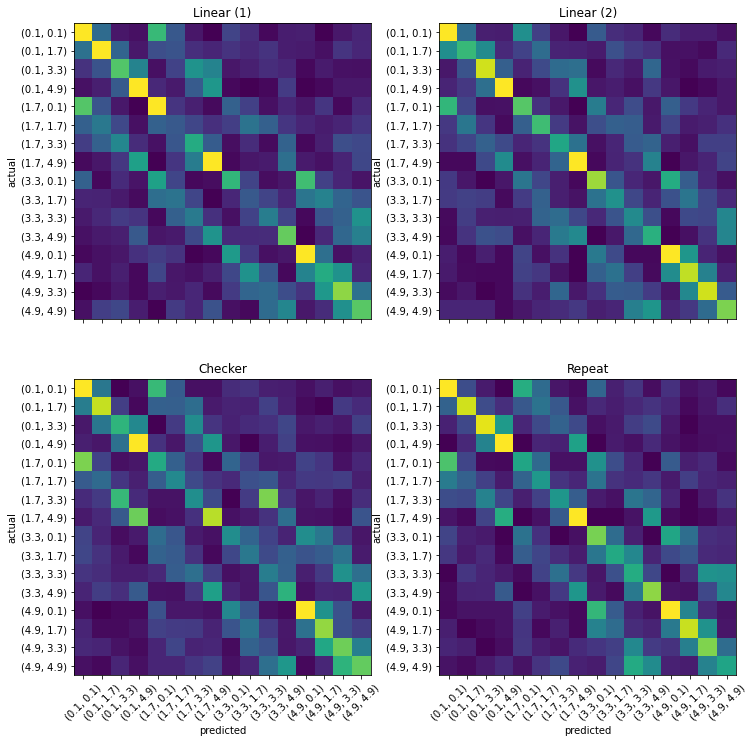

In [8]:
ri = 0;
plt.figure(figsize=(12,12))

grid_pt_strs = np.array(['(%.1f, %.1f)'%(grid_pts[ii,0], grid_pts[ii,1]) for ii in range(len(grid_pts))])

for ti in range(4):
    
    props = np.mean(prop_confusion[:,ri,ti,:,:], axis=0)
    
    # print(props.shape)
    plt.subplot(2,2,ti+1)
    
    plt.pcolormesh(props, vmin=0, vmax=0.30)
    plt.axis('square')
    plt.gca().invert_yaxis()
    # plt.colorbar()
    
    if ti>1:
        plt.xticks(np.arange(n_pts)+0.5, grid_pt_strs, rotation=45)
    else:
        plt.xticks(np.arange(n_pts)+0.5, [])
    plt.yticks(np.arange(n_pts)+0.5, grid_pt_strs)
    
    plt.ylabel('actual')
    if ti>1:
        plt.xlabel('predicted')
    
    plt.title(task_names[ti])

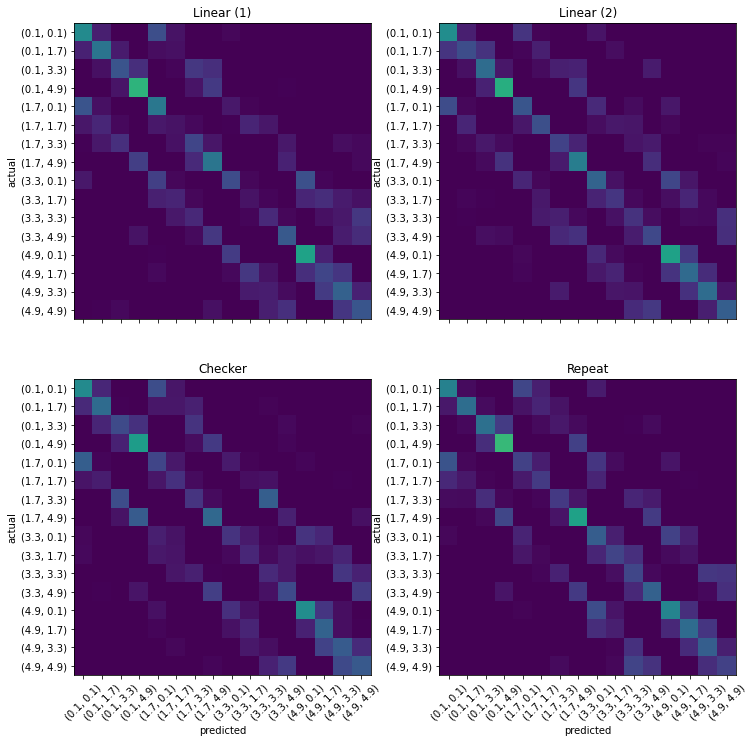

In [62]:
ri = 0;
plt.figure(figsize=(12,12))

grid_pt_strs = np.array(['(%.1f, %.1f)'%(grid_pts[ii,0], grid_pts[ii,1]) for ii in range(len(grid_pts))])

for ti in range(4):
    
    props = np.mean(prop_confusion[:,ri,ti,:,:], axis=0)
    
    # print(props.shape)
    plt.subplot(2,2,ti+1)
    
    plt.pcolormesh(props,vmin=0.05, vmax=0.7)
    plt.axis('square')
    plt.gca().invert_yaxis()
    
    if ti>1:
        plt.xticks(np.arange(n_pts)+0.5, grid_pt_strs, rotation=45)
    else:
        plt.xticks(np.arange(n_pts)+0.5, [])
    plt.yticks(np.arange(n_pts)+0.5, grid_pt_strs)
    
    plt.ylabel('actual')
    if ti>1:
        plt.xlabel('predicted')
    
    plt.title(task_names[ti])

#### load gist features

In [9]:
import h5py
f = []
feat_dir = os.path.join(root, 'Analysis', 'image_similarity', 'features')

fn = os.path.join(feat_dir, 'gist', 'Images_grid3_gistdescriptors_4ori_4blocks.h5py')
print(fn)
with h5py.File(fn, 'r') as file:
    
    f = np.array(file['/features'])
    file.close()
    
labs = pd.read_csv(os.path.join(feat_dir, 'Image_labels_grid3.csv'))

pts = np.array([labs['coord_axis1'], labs['coord_axis2']]).T

gi = [np.argmin(np.sum((pts-g)**2, axis=1)) for g in grid_pts]

f_main = f[gi,:]

# compute all pairwise euclidean distances
# inverting this so bigger=more similar
# gist_distances = np.corrcoef(f_main)
gist_distances = 1-scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(f_main, 'euclidean'))
# gist_distances = 1-scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(f_main, 'cosine'))


/usr/local/serenceslab/maggie/shapeDim/Analysis/image_similarity/features/gist/Images_grid3_gistdescriptors_4ori_4blocks.h5py


#### create templates

In [10]:
template_names = ['Linear 1','Linear 2','Checker','Quadrant', 'Individual shapes', 'GIST distances']
n_templates = 6;

ideal_conf_matrices = np.zeros((n_pts, n_pts, n_templates))


for gg1 in range(n_pts):
    
    for gg2 in range(n_pts):
        
        pt1 = grid_pts[gg1:gg1+1,:]
        pt2 = grid_pts[gg2:gg2+1,:]
        
        
        if grid_utils.get_categ(pt1, 1)==grid_utils.get_categ(pt2, 1):
            ideal_conf_matrices[gg1,gg2,0] = 1
        
        if grid_utils.get_categ(pt1, 2)==grid_utils.get_categ(pt2, 2):
            ideal_conf_matrices[gg1,gg2,1] = 1
        
        if grid_utils.get_categ(pt1, 3)==grid_utils.get_categ(pt2, 3):
            ideal_conf_matrices[gg1,gg2,2] = 1
        
        if grid_utils.get_quadrant(pt1)==grid_utils.get_quadrant(pt2):
            ideal_conf_matrices[gg1,gg2,3] = 1
        
        if gg1==gg2:
            ideal_conf_matrices[gg1,gg2,4] = 1
        
ideal_conf_matrices[:,:, 5] = gist_distances


In [11]:
template_corrs = np.zeros((n_templates, n_templates))
for ti1 in range(n_templates):
    for ti2 in range(n_templates):
        t1 = ideal_conf_matrices[:,:,ti1].ravel()
        t2 = ideal_conf_matrices[:,:,ti2].ravel()
        template_corrs[ti1, ti2] = np.corrcoef(t1, t2)[0,1]

In [12]:
ti_pairs = [[0,5],[1,5],[2,5]]
for pair in ti_pairs:
    print('%s vs %s'%(template_names[pair[0]], template_names[pair[1]]))
    print(template_corrs[pair[0], pair[1]].round(3))

Linear 1 vs GIST distances
0.444
Linear 2 vs GIST distances
0.547
Checker vs GIST distances
0.174


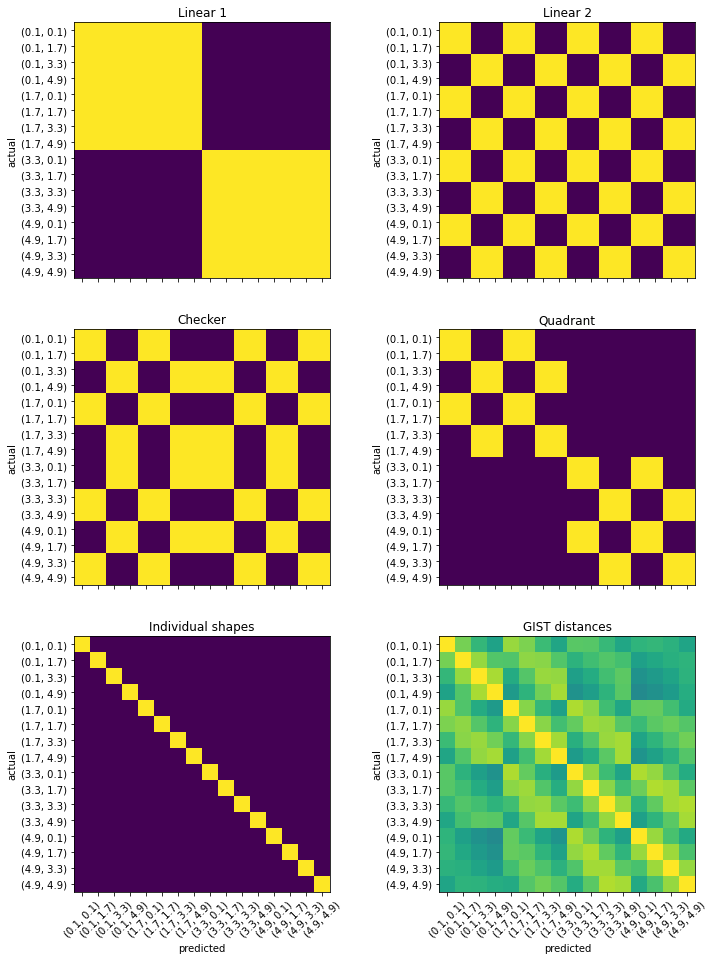

In [13]:
plt.figure(figsize=(12,16))

for ti in range(n_templates):
    
    plt.subplot(3,2,ti+1)
    plt.pcolormesh(ideal_conf_matrices[:,:,ti], vmin=0, vmax=1)
    plt.axis('square')
    plt.gca().invert_yaxis()
    
    if ti>3:
        plt.xticks(np.arange(n_pts)+0.5, grid_pt_strs, rotation=45)
        plt.xlabel('predicted')
    
    else:
        plt.xticks(np.arange(n_pts)+0.5, [])
    plt.yticks(np.arange(n_pts)+0.5, grid_pt_strs)
    
    plt.ylabel('actual')
        
        
    plt.title('%s'%template_names[ti])

#### compare actual confusions to templates

In [14]:
sim_each = np.zeros((n_subjects, n_rois, n_tasks, n_templates))

for si in range(n_subjects):

    for ri in range(n_rois):

        for ti in range(4):

            props = prop_confusion[si,ri,ti,:,:]
    
            for tmpi in range(n_templates):

                template = ideal_conf_matrices[:,:,tmpi]

                sim_each[si,ri,ti,tmpi] = np.corrcoef(props.ravel(), template.ravel())[0,1]

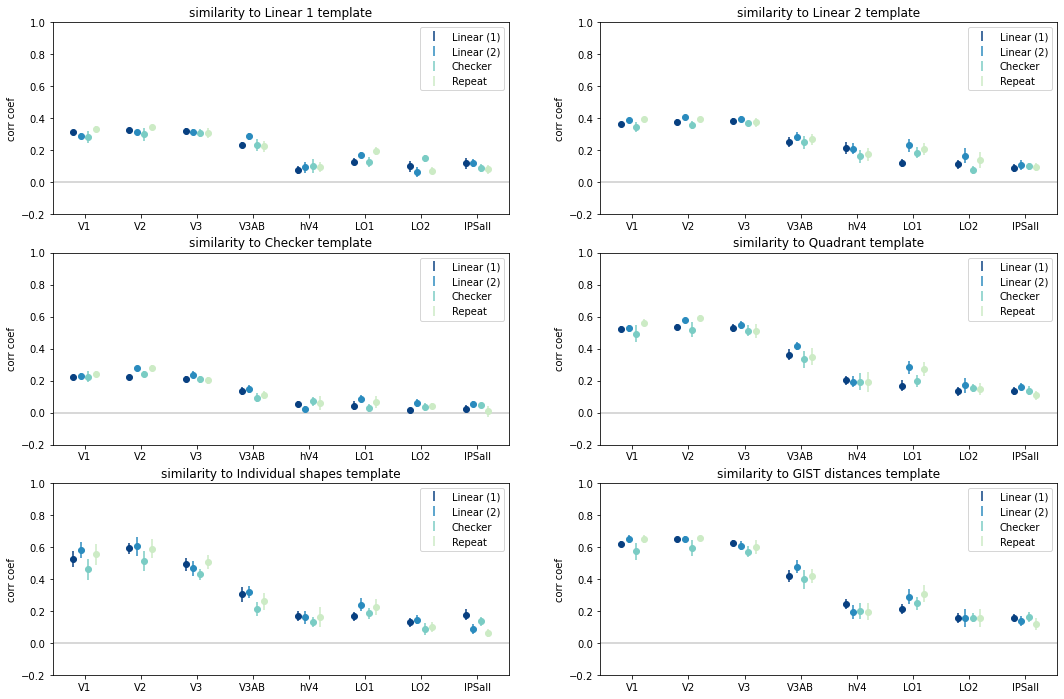

In [15]:
plt.figure(figsize=(18,12))

ti_plot = [0,1,2,3]

x_jitter = np.linspace(-0.2, 0.2, len(ti_plot))

for tmpi, tmpname in enumerate(template_names):
    
    plt.subplot(3,2, tmpi+1)
    
    plt.axhline(0, color=[0.8, 0.8, 0.8])

    lh = []

    for tii, ti in enumerate(ti_plot):

        x_ticks = np.arange(n_rois) + x_jitter[tii]

        vals = sim_each[:,:,ti,tmpi]
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0) / np.sqrt(n_subjects)
        
        plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)

    plt.ylim([-0.2, 1.0])
    # plt.ylim([-0.5, 0.5])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('corr coef')

    plt.legend(lh,task_names)

    plt.title('similarity to %s template'%tmpname)


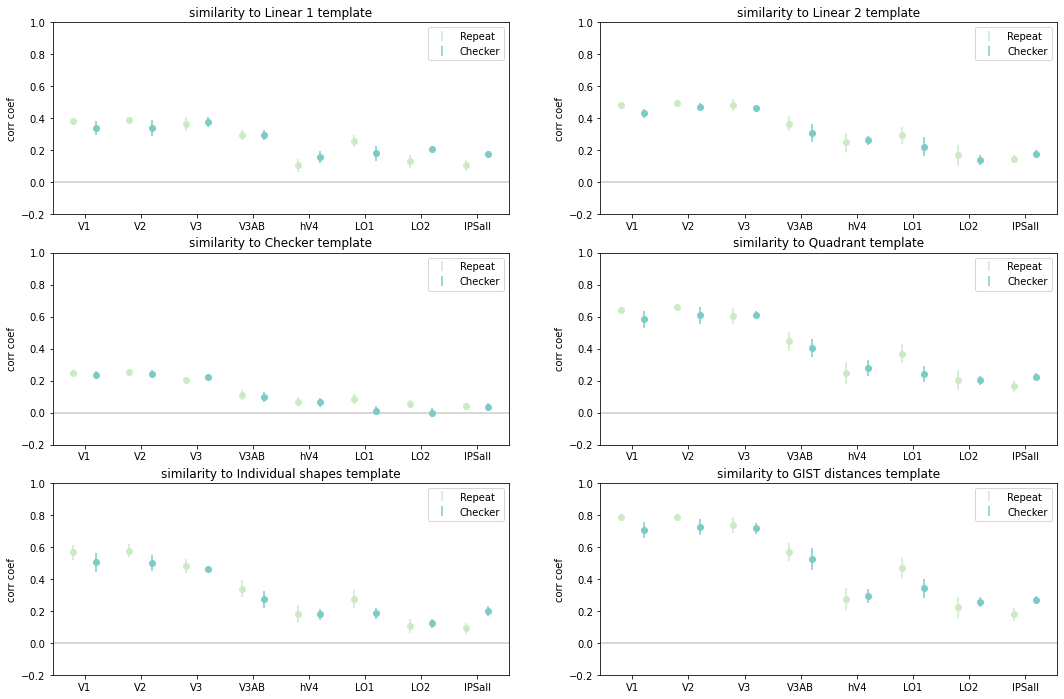

In [25]:
plt.figure(figsize=(18,12))

ti_plot = [3,2]

x_jitter = np.linspace(-0.2, 0.2, len(ti_plot))

for tmpi, tmpname in enumerate(template_names):
    
    plt.subplot(3,2, tmpi+1)
    
    plt.axhline(0, color=[0.8, 0.8, 0.8])

    lh = []

    for tii, ti in enumerate(ti_plot):

        x_ticks = np.arange(n_rois) + x_jitter[tii]

        vals = sim_each[:,:,ti,tmpi]
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0) / np.sqrt(n_subjects)
        
        plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)

    plt.ylim([-0.2, 1.0])
    # plt.ylim([-0.5, 0.5])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('corr coef')

    plt.legend(lh,np.array(task_names)[ti_plot])

    plt.title('similarity to %s template'%tmpname)


#### plotting two linear tasks only

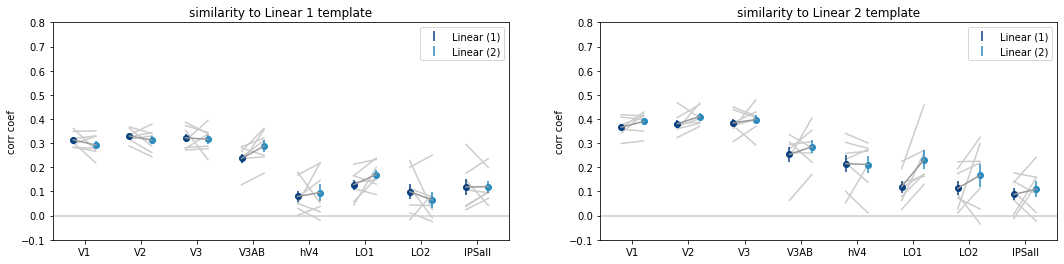

In [16]:
plt.figure(figsize=(18,4))

ti_plot = [0,1]

x_jitter = np.linspace(-0.2, 0.2, len(ti_plot))

for tmpi, tmpname in enumerate(template_names[0:2]):
    
    plt.subplot(1,2,tmpi+1)
    plt.axhline(0, color=[0.8, 0.8, 0.8])

    lh = []

    for tii, ti in enumerate(ti_plot):

        x_ticks = np.arange(n_rois) + x_jitter[tii]

        vals = sim_each[:,:,ti,tmpi]
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0) / np.sqrt(n_subjects)
        
        plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)

    for ri in range(n_rois):
            
        meanvals = np.mean(sim_each[:,ri,ti_plot,tmpi], axis=0)
        plt.plot(ri+x_jitter, meanvals,'-',color=[0.6, 0.6, 0.6])

        plt.plot(ri+x_jitter, sim_each[:,ri,ti_plot,tmpi].T, color=[0.8, 0.8, 0.8], zorder=-10)

    plt.ylim([-0.1, 0.8])
    # plt.ylim([-0.5, 0.5])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('corr coef')

    plt.legend(lh,task_names)

    plt.title('similarity to %s template'%tmpname)

In [17]:
ti_plot = [0,1]


for tmpi, tmpname in enumerate(template_names[0:2]):

    vals = copy.deepcopy(sim_each[:,:,ti_plot,tmpi])

    tstats = np.zeros((n_rois,),dtype=float)
    pvals = np.zeros((n_rois,),dtype=float)

    n_subs_samedir = np.zeros((n_rois,),dtype=int)

    rndseed = 2343434
    for rr in range(n_rois):
        
        vals1 = vals[:,rr,0]
        vals2 = vals[:,rr,1]

        p, t = stats_utils.paired_ttest_nonpar(vals1, vals2, \
                                               n_iter=10000, rndseed=rndseed)    
        pvals[rr] = p
        tstats[rr] = t;

        subj_diffs = vals1 - vals2
        n_subs_samedir[rr] = np.maximum(np.sum(subj_diffs>0), np.sum(subj_diffs<0))

    print('\nsimilarity to %s template'%tmpname)
    task_df = pd.DataFrame({'t-stat for task 1 > task 2': tstats, \
                            'pvalue': pvals, \
                               'n_subs_indiv': n_subs_samedir}, \
                              index=roi_names)
    print(task_df.round(3))


similarity to Linear 1 template
        t-stat for task 1 > task 2  pvalue  n_subs_indiv
V1                           1.196   0.330             4
V2                           1.069   0.352             4
V3                           0.229   0.874             4
V3AB                        -2.454   0.051             6
hV4                         -0.454   0.692             4
LO1                         -1.610   0.177             5
LO2                          0.896   0.385             5
IPSall                      -0.055   0.934             4

similarity to Linear 2 template
        t-stat for task 1 > task 2  pvalue  n_subs_indiv
V1                          -1.746   0.195             4
V2                          -1.523   0.211             6
V3                          -0.549   0.607             4
V3AB                        -0.941   0.382             4
hV4                          0.116   0.962             4
LO1                         -3.406   0.017             7
LO2                   

In [18]:
ti_plot = [0,1]

x_jitter = np.linspace(-0.2, 0.2, len(ti_plot))

for tmpi, tmpname in enumerate(template_names[0:2]):

    vals = copy.deepcopy(sim_each[:,:,ti_plot, tmpi])

    anova_result = stats_utils.rmanova_2way(vals, ['roi','task'], do_shuffle=False)

    anova_result['Pr > F'] = anova_result['Pr > F'].round(4)

    print('\nAnova for similarity to %s template'%(tmpname))
    print(anova_result)



Anova for similarity to Linear 1 template
            F Value  Num DF  Den DF  Pr > F
roi       34.165590     7.0    42.0  0.0000
task       0.187056     1.0     6.0  0.6805
roi:task   1.237504     7.0    42.0  0.3045

Anova for similarity to Linear 2 template
            F Value  Num DF  Den DF  Pr > F
roi       31.925374     7.0    42.0  0.0000
task       9.626859     1.0     6.0  0.0210
roi:task   1.168475     7.0    42.0  0.3411


#### below are some scraps of other analyses, not using

In [153]:
np.mean(r2_cross_subj, axis=0).round(2)

array([[ 2.500e-01,  4.800e-01,  3.200e-01,  5.700e-01],
       [ 6.200e-01,  4.700e-01,  5.200e-01,  4.100e-01],
       [ 5.500e-01,  5.200e-01,  4.600e-01, -1.649e+01],
       [-5.000e-02,  3.100e-01,  1.800e-01,  2.900e-01],
       [-5.430e+00, -1.300e+00,  2.000e-02, -2.270e+00],
       [-6.000e-02,  9.000e-02, -6.770e+00, -7.500e-01],
       [ 5.000e-02, -1.000e-01, -3.600e-01, -1.000e-02],
       [-1.000e-02,  4.000e-02,  5.000e-02, -6.000e-02]])

In [151]:
np.max(r2_cross_subj)

0.7919946827986406

In [145]:
sstot

0.003144772199356782

In [146]:
ssres

0.004949477679581517

In [143]:
r2_same

0.23583098239549638

In [144]:
r2

-0.5738747883213484

In [139]:
actual.shape

(256,)

In [132]:
r2

-432.64748501575133

In [130]:
all_feats.shape

(256, 6)

In [128]:
other_subj_props = np.array([prop_confusion[osi,ri,ti,:,:].ravel() for osi in other_subj]).T
other_subj_props.shape

(256, 6)

In [126]:
other_subj = np.arange(n_subjects)[np.arange(n_subjects)!=si]
other_subj

array([0, 1, 2, 3, 4, 5])

In [124]:
partial_corr_each = np.zeros((n_subjects, n_rois, n_tasks, n_templates))

for si in range(n_subjects):

    for ri in range(n_rois):

        for ti in range(4):

            props = prop_confusion[si,ri,ti,:,:].ravel()
    
            for tmpi in range(n_templates):

                target_feats = ideal_conf_matrices[:,:,tmpi].ravel()

                # other_inds = np.arange(n_templates)[np.arange(n_templates)!=tmpi]
                other_feats = np.array([ideal_conf_matrices[:,:,oi].ravel() for oi in [3]]).T
                # other_feats = np.array([ideal_conf_matrices[:,:,oi].ravel() for oi in [3,5]]).T
                # other_feats = np.array([ideal_conf_matrices[:,:,oi].ravel() for oi in [3,5]]).T
                # other_feats = np.array([ideal_conf_matrices[:,:,oi].ravel() for oi in [3,4,5]]).T
                
                # other_feats = ideal_conf_matrices[:,:,5].ravel()
                # other_feats = ideal_conf_matrices[:,:,5].ravel()
                
                partial_corr_each[si,ri,ti,tmpi] = stats_utils.compute_partial_corr(target_feats, props, other_feats)

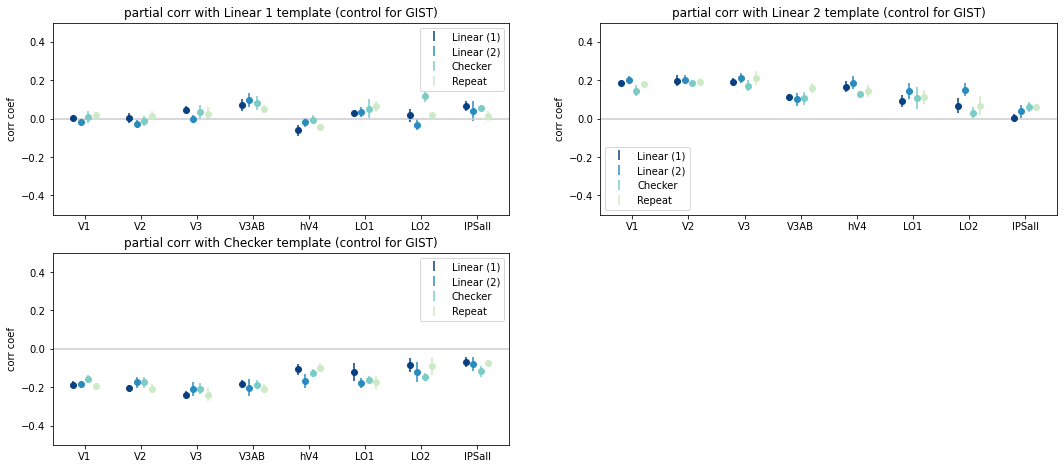

In [125]:
plt.figure(figsize=(18,12))

ti_plot = [0,1,2,3]

x_jitter = np.linspace(-0.2, 0.2, len(ti_plot))

for tmpi, tmpname in enumerate(template_names[0:-3]):
    
    plt.subplot(3,2, tmpi+1)
    
    plt.axhline(0, color=[0.8, 0.8, 0.8])

    lh = []

    for tii, ti in enumerate(ti_plot):

        x_ticks = np.arange(n_rois) + x_jitter[tii]

        vals = partial_corr_each[:,:,ti,tmpi]
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0) / np.sqrt(n_subjects)
        
        plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)

    # plt.ylim([-0.2, 1.0])
    plt.ylim([-0.5, 0.5])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('corr coef')

    plt.legend(lh,task_names)

    plt.title('partial corr with %s template (control for GIST)'%tmpname)


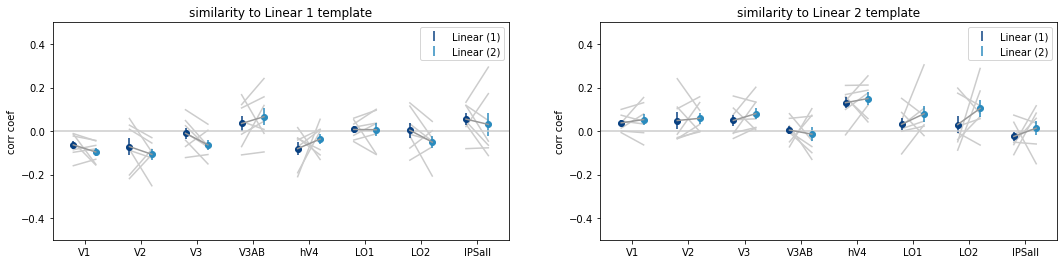

In [123]:
plt.figure(figsize=(18,4))

ti_plot = [0,1]

x_jitter = np.linspace(-0.2, 0.2, len(ti_plot))

for tmpi, tmpname in enumerate(template_names[0:2]):
    
    plt.subplot(1,2,tmpi+1)
    plt.axhline(0, color=[0.8, 0.8, 0.8])

    lh = []

    for tii, ti in enumerate(ti_plot):

        x_ticks = np.arange(n_rois) + x_jitter[tii]

        vals = partial_corr_each[:,:,ti,tmpi]
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0) / np.sqrt(n_subjects)
        
        plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)

    for ri in range(n_rois):
            
        meanvals = np.mean(partial_corr_each[:,ri,ti_plot,tmpi], axis=0)
        plt.plot(ri+x_jitter, meanvals,'-',color=[0.6, 0.6, 0.6])

        plt.plot(ri+x_jitter, partial_corr_each[:,ri,ti_plot,tmpi].T, color=[0.8, 0.8, 0.8], zorder=-10)

    # plt.ylim([-0.1, 0.6])
    plt.ylim([-0.5, 0.5])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('corr coef')

    plt.legend(lh,task_names)

    plt.title('similarity to %s template'%tmpname)

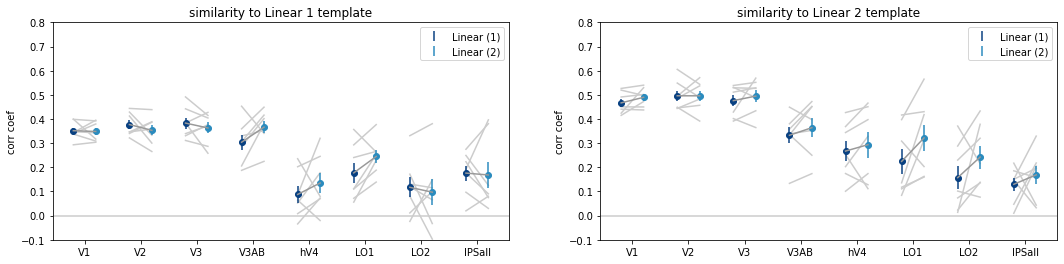

In [76]:
plt.figure(figsize=(18,4))

ti_plot = [0,1]

x_jitter = np.linspace(-0.2, 0.2, len(ti_plot))

for tmpi, tmpname in enumerate(template_names[0:2]):
    
    plt.subplot(1,2,tmpi+1)
    plt.axhline(0, color=[0.8, 0.8, 0.8])

    lh = []

    for tii, ti in enumerate(ti_plot):

        x_ticks = np.arange(n_rois) + x_jitter[tii]

        vals = sim_each[:,:,ti,tmpi]
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0) / np.sqrt(n_subjects)
        
        plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)

    for ri in range(n_rois):
            
        meanvals = np.mean(sim_each[:,ri,ti_plot,tmpi], axis=0)
        plt.plot(ri+x_jitter, meanvals,'-',color=[0.6, 0.6, 0.6])

        plt.plot(ri+x_jitter, sim_each[:,ri,ti_plot,tmpi].T, color=[0.8, 0.8, 0.8], zorder=-10)

    plt.ylim([-0.1, 0.8])
    # plt.ylim([-0.5, 0.5])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('corr coef')

    plt.legend(lh,task_names)

    plt.title('similarity to %s template'%tmpname)

In [74]:
ti_plot = [0,1]


for tmpi, tmpname in enumerate(template_names[0:2]):

    vals = copy.deepcopy(sim_each[:,:,ti_plot,tmpi])

    tstats = np.zeros((n_rois,),dtype=float)
    pvals = np.zeros((n_rois,),dtype=float)

    n_subs_samedir = np.zeros((n_rois,),dtype=int)

    rndseed = 2343434
    for rr in range(n_rois):
        
        vals1 = vals[:,rr,0]
        vals2 = vals[:,rr,1]

        p, t = stats_utils.paired_ttest_nonpar(vals1, vals2, \
                                               n_iter=10000, rndseed=rndseed)    
        pvals[rr] = p
        tstats[rr] = t;

        subj_diffs = vals1 - vals2
        n_subs_samedir[rr] = np.maximum(np.sum(subj_diffs>0), np.sum(subj_diffs<0))

    print('\nsimilarity to %s template'%tmpname)
    task_df = pd.DataFrame({'t-stat for task 1 > task 2': tstats, \
                            'pvalue': pvals, \
                               'n_subs_indiv': n_subs_samedir}, \
                              index=roi_names)
    print(task_df.round(3))


similarity to Linear 1 template
        t-stat for task 1 > task 2  pvalue  n_subs_indiv
V1                           0.183   0.906             4
V2                           0.988   0.329             4
V3                           0.818   0.477             4
V3AB                        -1.789   0.121             6
hV4                         -0.953   0.402             5
LO1                         -2.079   0.110             6
LO2                          0.389   0.722             4
IPSall                       0.156   0.874             4

similarity to Linear 2 template
        t-stat for task 1 > task 2  pvalue  n_subs_indiv
V1                          -1.391   0.281             4
V2                           0.007   0.995             4
V3                          -0.806   0.565             4
V3AB                        -1.079   0.313             5
hV4                         -0.758   0.452             5
LO1                         -1.903   0.123             6
LO2                   

In [77]:
ti_plot = [0,1]

x_jitter = np.linspace(-0.2, 0.2, len(ti_plot))

for tmpi, tmpname in enumerate(template_names[0:2]):

    vals = copy.deepcopy(sim_each[:,:,ti_plot, tmpi])

    anova_result = stats_utils.rmanova_2way(vals, ['roi','task'], do_shuffle=False)

    anova_result['Pr > F'] = anova_result['Pr > F'].round(4)

    print('\nAnova for similarity to %s template'%(tmpname))
    print(anova_result)



Anova for similarity to Linear 1 template
            F Value  Num DF  Den DF  Pr > F
roi       17.076414     7.0    42.0  0.0000
task       0.531559     1.0     6.0  0.4934
roi:task   1.209246     7.0    42.0  0.3191

Anova for similarity to Linear 2 template
            F Value  Num DF  Den DF  Pr > F
roi       21.838729     7.0    42.0  0.0000
task      21.011364     1.0     6.0  0.0038
roi:task   0.649685     7.0    42.0  0.7125


In [83]:
ti_plot = [0,1]

vals = copy.deepcopy(sim_each[:,:,ti_plot,:][:,:,:,[0,1]])

anova_result = stats_utils.rmanova_3way(vals, ['roi','task', 'template'], do_shuffle=False)

anova_result['Pr > F'] = anova_result['Pr > F'].round(4)

print(anova_result)


                     F Value  Num DF  Den DF  Pr > F
roi                22.423028     7.0    42.0  0.0000
task                8.071238     1.0     6.0  0.0295
template           36.371355     1.0     6.0  0.0009
roi:task            1.056787     7.0    42.0  0.4077
roi:template        6.950489     7.0    42.0  0.0000
task:template       1.805232     1.0     6.0  0.2277
roi:task:template   0.666936     7.0    42.0  0.6985


In [101]:
coeffs_each = np.zeros((n_subjects, n_rois, n_tasks, n_templates))

for si in range(n_subjects):

    for ri in range(n_rois):

        for ti in range(4):

            props = prop_confusion[si,ri,ti,:,:].ravel()[:,None]
    
            all_feats = np.array([ideal_conf_matrices[:,:,oi].ravel() for oi in np.arange(n_templates)]).T
            
            yhat, reg_coeffs, r2 = stats_utils.lin_reg(all_feats, props)
            
            coeffs_each[si,ri,ti,:] = reg_coeffs[0:n_templates][:,0]
            # stdbetas = reg_coeffs[0:n_templates] * np.std(all_feats, axis=0) / np.std(props, axis=0)
            
            # coeffs_each[si,ri,ti,:] = stdbetas[:,0]

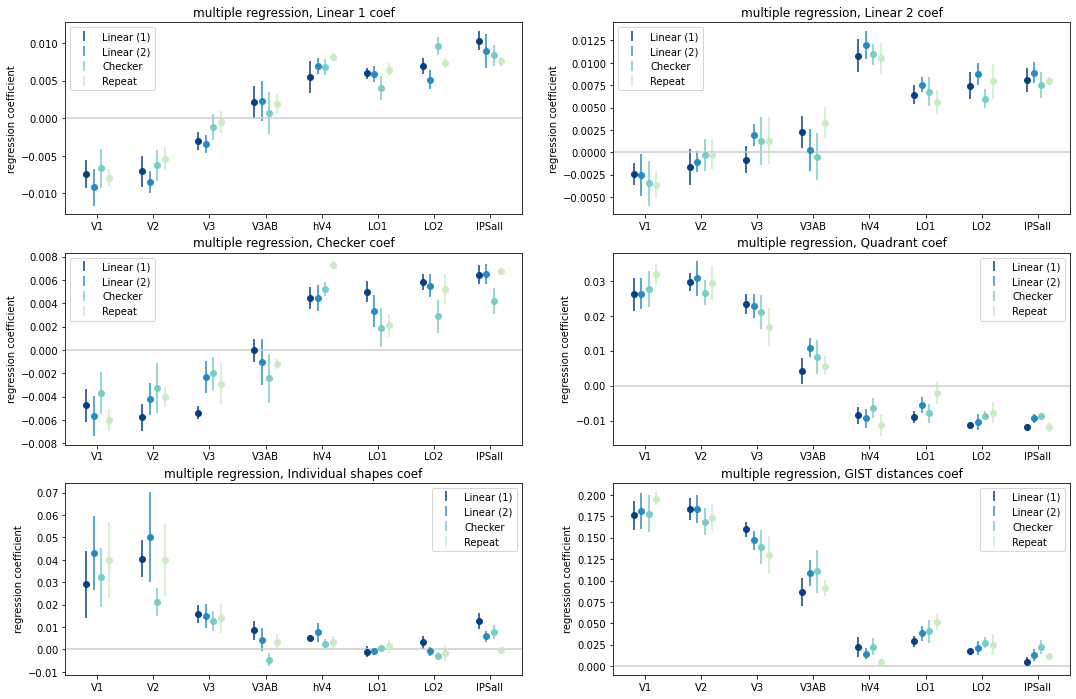

In [102]:
plt.figure(figsize=(18,12))

ti_plot = [0,1,2,3]

x_jitter = np.linspace(-0.2, 0.2, len(ti_plot))

for tmpi, tmpname in enumerate(template_names[0:n_templates]):
    
    plt.subplot(3,2, tmpi+1)
    
    plt.axhline(0, color=[0.8, 0.8, 0.8])

    lh = []

    for tii, ti in enumerate(ti_plot):

        x_ticks = np.arange(n_rois) + x_jitter[tii]

        vals = coeffs_each[:,:,ti,tmpi]
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0) / np.sqrt(n_subjects)
        
        plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti])
        h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
        lh.append(h)

    # plt.ylim([-0.2, 1.0])
    # plt.ylim([-0.5, 0.5])

    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('regression coefficient')

    plt.legend(lh,task_names)

    plt.title('multiple regression, %s coef'%tmpname)


In [93]:
reg_coeffs.shape

(7, 1)

In [147]:
r2_cross_subj = np.zeros((n_subjects, n_rois, n_tasks))

all_feats = np.array([ideal_conf_matrices[:,:,ii].ravel() for ii in np.arange(n_templates)]).T
            
for si in range(n_subjects):
    
    other_subj = np.arange(n_subjects)[np.arange(n_subjects)!=si]

    for ri in range(n_rois):

        for ti in range(4):

            props = prop_confusion[si,ri,ti,:,:].ravel()[:,None]
    
            other_subj_props = np.array([prop_confusion[osi,ri,ti,:,:].ravel() for osi in other_subj]).T
    
            yhat, reg_coeffs, r2_same = stats_utils.lin_reg(all_feats, np.mean(other_subj_props, axis=1))
        
            pred = np.squeeze(yhat)
            actual = np.squeeze(props)
            ssres = np.sum(np.power((actual - pred),2));
            sstot = np.sum(np.power((actual - np.mean(actual)),2));
            r2 = 1-(ssres/sstot)
            
            r2_cross_subj[si,ri,ti] = r2
            # coeffs_each[si,ri,ti,:] = reg_coeffs[0:n_templates][:,0]
            # stdbetas = reg_coeffs[0:n_templates] * np.std(all_feats, axis=0) / np.std(props, axis=0)
            
            # coeffs_each[si,ri,ti,:] = stdbetas[:,0]